In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
# This workbook throws sklearn.linear_model.LogisiticRegression at
# the 2016 version of the titanic survivors dataset containing the
# crew as well as the passengers.

# LogisticRegression, confusion matrices, and ROC curves.


In [ ]:
# This dataset was included in the R package DALEX; it appears to date to 
# 2016, where it was created by augmenting an older titanic3 dataset with the crew fates.

# Since the authors of DALEX were not trying to improve on the recordkeeping
# of early-20th-century ocean liners, I am unsure who precisely to credit the
# compilation of the dataset to.

# https://cran.r-project.org/web/packages/DALEX/index.html

# https://modeloriented.github.io/EIX/reference/titanic_data.html

In [ ]:
# I've taken some inspiration from the linkedin / blog post by Murilo Gustineli
#  Murilo Gustineli  "What I learned analyzing the famous Titanic dataset"  Nov 9, 2020.

# https://www.linkedin.com/pulse/what-i-learned-analyzing-famous-titanic-dateset-murilo-gustineli 


In [3]:
titanic=pd.read_csv("../data/titanic_data.csv")
titanic

,Unnamed: 0,gender,age,class,embarked,country,fare,sibsp,parch,survived
0,1,male,42.0,3rd,Southampton,United States,7.11,0.0,0.0,no
1,2,male,13.0,3rd,Southampton,United States,20.05,0.0,2.0,no
2,3,male,16.0,3rd,Southampton,United States,20.05,1.0,1.0,no
3,4,female,39.0,3rd,Southampton,England,20.05,1.0,1.0,yes
4,5,female,16.0,3rd,Southampton,Norway,7.13,0.0,0.0,yes
...,...,...,...,...,...,...,...,...,...,...
2202,2203,male,41.0,deck crew,Belfast,England,0.00,0.0,0.0,yes
2203,2204,male,40.0,victualling crew,Southampton,England,0.00,0.0,0.0,yes
2204,2205,male,32.0,engineering crew,Southampton,England,0.00,0.0,0.0,no
2205,2206,male,20.0,restaurant staff,Southampton,England,0.00,0.0,0.0,no


In [4]:
# A field named lower-case class is not going to play nicely 
# with python attribute syntax:
titanic["Class"] = titanic["class"]
titanic = titanic.drop("class", axis=1)
titanic.head(1)

,Unnamed: 0,gender,age,embarked,country,fare,sibsp,parch,survived,Class
0,1,male,42.0,Southampton,United States,7.11,0.0,0.0,no,3rd


In [5]:
#convert gender into a number.
titanic["Gender" ] = (titanic ["gender"] == "male") * 1.0
titanic = titanic.drop("gender", axis=1 )

In [6]:
titanic.head(1)

,Unnamed: 0,age,embarked,country,fare,sibsp,parch,survived,Class,Gender
0,1,42.0,Southampton,United States,7.11,0.0,0.0,no,3rd,1.0


In [7]:
# remove nuisance index
titanic=titanic.drop("Unnamed: 0", axis=1)

In [8]:
# convert survived into a number
titanic["Survived"] = (titanic.survived == "yes" )*1.0
titanic = titanic.drop("survived", axis=1)

In [9]:
titanic.Survived.value_counts()

0.0    1496
1.0     711
Name: Survived, dtype: int64

In [10]:
titanic["Class"].value_counts()

3rd                 709
victualling crew    431
1st                 324
engineering crew    324
2nd                 284
restaurant staff     69
deck crew            66
Name: Class, dtype: int64

In [11]:
titanic.groupby(["Class", "Survived"]).Survived.count()

Class             Survived
1st               0.0         123
                  1.0         201
2nd               0.0         166
                  1.0         118
3rd               0.0         528
                  1.0         181
deck crew         0.0          23
                  1.0          43
engineering crew  0.0         253
                  1.0          71
restaurant staff  0.0          66
                  1.0           3
victualling crew  0.0         337
                  1.0          94
Name: Survived, dtype: int64

In [12]:
titanic.describe()

,age,fare,sibsp,parch,Gender,Survived
count,2205.000000,2181.000000,2197.000000,2197.000000,2207.000000,2207.000000
mean,30.436735,19.773290,0.297223,0.229404,0.778432,0.322157
std,12.159677,43.402454,0.840384,0.694232,0.415396,0.467409
min,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,29.000000,7.150600,0.000000,0.000000,1.000000,0.000000
75%,38.000000,20.110600,0.000000,0.000000,1.000000,1.000000
max,74.000000,512.060700,8.000000,9.000000,1.000000,1.000000


In [14]:
titanic.isnull()

,age,embarked,country,fare,sibsp,parch,Class,Gender,Survived
0,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
2202,False,False,False,False,False,False,False,False,False
2203,False,False,False,False,False,False,False,False,False
2204,False,False,False,False,False,False,False,False,False
2205,False,False,False,False,False,False,False,False,False


In [13]:
(titanic.isnull().sum(axis=1)).value_counts()

0    2099
1      98
3       9
4       1
dtype: int64

In [15]:
# There are only a handful of rows with three missing values

titanic.loc[titanic.isnull().sum(axis=1)>1,:]

,age,embarked,country,fare,sibsp,parch,Class,Gender,Survived
144,24.0,Southampton,England,NaN,NaN,NaN,2nd,1.0,0.0
150,20.0,Southampton,France,NaN,NaN,NaN,2nd,1.0,0.0
237,28.0,Southampton,England,NaN,NaN,NaN,2nd,1.0,0.0
516,33.0,Southampton,England,NaN,NaN,NaN,2nd,1.0,0.0
576,21.0,Southampton,NaN,NaN,NaN,NaN,2nd,1.0,0.0
615,49.0,Southampton,United States,NaN,NaN,NaN,3rd,1.0,0.0
680,23.0,Southampton,England,NaN,NaN,NaN,2nd,1.0,0.0
1094,35.0,Southampton,Ireland,NaN,NaN,NaN,3rd,1.0,0.0
1189,40.0,Southampton,England,NaN,NaN,NaN,2nd,1.0,0.0
1304,32.0,Southampton,England,NaN,NaN,NaN,2nd,1.0,0.0


In [16]:
# I know that I can't look at all 200 one-value-missing rows, 
# so I'll take a subset of them to examine:
titanic.loc[titanic.isnull().sum(axis=1)==1,:].sample(5)

,age,embarked,country,fare,sibsp,parch,Class,Gender,Survived
870,22.0,Southampton,NaN,7.1711,0.0,0.0,3rd,1.0,0.0
131,26.0,Southampton,NaN,7.1711,0.0,0.0,3rd,1.0,0.0
613,4.0,Southampton,NaN,11.0208,1.0,1.0,3rd,1.0,1.0
591,19.0,Cherbourg,NaN,14.0901,1.0,0.0,3rd,0.0,0.0
1830,23.0,Southampton,NaN,0.0000,0.0,0.0,engineering crew,1.0,0.0


In [ ]:
# I wasn't planning on using nationality anyway.

In [17]:
titanic["fare"] = titanic.fare.fillna(0)
titanic["sibsp"] = titanic.sibsp.fillna(0)
titanic["parch"] = titanic.parch.fillna(0)


In [18]:
from sklearn.linear_model import LogisticRegression

In [19]:
X = titanic[["age", "Gender", "sibsp", "parch" ]].values
X

array([[42.,  1.,  0.,  0.],
       [13.,  1.,  0.,  2.],
       [16.,  1.,  1.,  1.],
       ...,
       [32.,  1.,  0.,  0.],
       [20.,  1.,  0.,  0.],
       [26.,  1.,  0.,  0.]])

In [21]:
Y = titanic.Survived.values
Y

array([0., 0., 0., ..., 0., 0., 0.])

In [22]:
lrfit = LogisticRegression().fit (X, Y)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [23]:
titanic[["age", "Gender", "sibsp", "parch" ]].isnull().sum(axis=0)

age       2
Gender    0
sibsp     0
parch     0
dtype: int64

In [24]:
titanic.loc[ titanic.age.isnull()]

,age,embarked,country,fare,sibsp,parch,Class,Gender,Survived
439,NaN,Cherbourg,Bulgaria,7.1711,0.0,0.0,3rd,1.0,0.0
677,NaN,Cherbourg,Bulgaria,7.1711,0.0,0.0,3rd,1.0,0.0


In [26]:
titanic.loc[ titanic.country== "Bulgaria"]

,age,embarked,country,fare,sibsp,parch,Class,Gender,Survived
46,26.0,Southampton,Bulgaria,7.1711,0.0,0.0,3rd,1.0,0.0
95,23.0,Southampton,Bulgaria,7.1711,0.0,0.0,3rd,1.0,0.0
246,24.0,Southampton,Bulgaria,7.1711,0.0,0.0,3rd,1.0,0.0
254,36.0,Southampton,Bulgaria,7.1711,0.0,0.0,3rd,1.0,0.0
439,NaN,Cherbourg,Bulgaria,7.1711,0.0,0.0,3rd,1.0,0.0
589,20.0,Southampton,Bulgaria,7.1711,0.0,0.0,3rd,1.0,0.0
624,23.0,Southampton,Bulgaria,7.1711,0.0,0.0,3rd,1.0,0.0
677,NaN,Cherbourg,Bulgaria,7.1711,0.0,0.0,3rd,1.0,0.0
771,35.0,Southampton,Bulgaria,7.1711,0.0,0.0,3rd,1.0,0.0
775,30.0,Cherbourg,Bulgaria,7.1711,0.0,0.0,3rd,1.0,0.0


In [25]:
titanic.loc[ titanic.country== "Bulgaria"].dropna().age.mean()

25.058823529411764

In [27]:
titanic["age"] = titanic.age.fillna("25")


In [28]:
X = titanic[["age", "Gender", "sibsp", "parch" ]].values
Y = titanic.Survived.values

In [29]:
lrfit = LogisticRegression().fit(X, Y)

In [31]:
#help(lrfit)

In [ ]:
#dir(lrfit)

In [32]:
lrfit.coef_

array([[-0.00840796, -2.48067048, -0.29642154, -0.00980207]])

In [33]:
np.std(X.astype("float"), axis=0)

array([12.15251085,  0.41530167,  0.8385243 ,  0.69267132])

In [34]:
np.multiply( lrfit.coef_[0] , np.std(X.astype("float"), axis=0))

array([-0.10217777, -1.03022659, -0.24855666, -0.00678961])

In [ ]:
#help(lrfit)

In [ ]:
# X = titanic[["age", "Gender", "sibsp", "parch" ]].values

Eyeballing these scaled-coefficient values, Gender and presence of siblings 
seem to be most important, but we don't yet use class / employee status

In [35]:
# sklearn has a convenience function to collate the confusion matrix.
# This is a binary problem.. 

from sklearn.metrics import confusion_matrix
confusion_matrix(Y, lrfit.predict(X))

array([[1373,  123],
       [ 352,  359]])

In [36]:
np.trace(confusion_matrix(Y, lrfit.predict(X))) / np.sum(confusion_matrix(Y, lrfit.predict(X)))

0.7847757136384232

In [39]:
lrfit.coef_, lrfit.intercept_

(array([[-0.00840796, -2.48067048, -0.29642154, -0.00980207]]),
 array([1.44128572]))

In [37]:
1-titanic.Survived.mean()

0.6778432260987766

In [ ]:
# If we predicted "Everybody dies" we would have 1 - 0.322 = 0.678   accuracy.

In [42]:
titanic.Class.value_counts()

3rd                 709
victualling crew    431
1st                 324
engineering crew    324
2nd                 284
restaurant staff     69
deck crew            66
Name: Class, dtype: int64

In [43]:
from sklearn.preprocessing import OneHotEncoder

In [44]:
CLASSX = OneHotEncoder().fit(titanic.Class)

ValueError: Expected 2D array, got 1D array instead:
array=['3rd' '3rd' '3rd' ... 'engineering crew' 'restaurant staff'
 'restaurant staff'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [45]:
encoder = OneHotEncoder().fit(titanic.Class.values.reshape(-1, 1))
encoder.transform(titanic.Class.values.reshape(-1, 1))

<2207x7 sparse matrix of type '<class 'numpy.float64'>'
	with 2207 stored elements in Compressed Sparse Row format>

In [ ]:
# This has a sparse output .. this might cause something downstream to 
# have indigestion.. 
# Documentation says https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html 
# OneHotEncoder() takes sparse_output=False option...

In [46]:
encoder = OneHotEncoder(sparse_output=False).fit(titanic.Class.values.reshape(-1, 1))
encoder.transform(titanic.Class.values.reshape(-1, 1))

TypeError: __init__() got an unexpected keyword argument 'sparse_output'

In [47]:
# My version of sklearn does not match the documentation...
encoder = OneHotEncoder(sparse=False).fit(titanic.Class.values.reshape(-1, 1))
CLASSX = encoder.transform(titanic.Class.values.reshape(-1, 1))
CLASSX

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [50]:
CLASSX.shape

(2207, 7)

In [48]:
# I can't use this without more information...  uh.. 
# OneHotEncoder().categories_
encoder.categories_

[array(['1st', '2nd', '3rd', 'deck crew', 'engineering crew',
        'restaurant staff', 'victualling crew'], dtype=object)]

In [49]:
XAUGMENTED = np.hstack([X, CLASSX])

In [ ]:
XAUGMENTED.shape

In [52]:
# For my sanity, keep track of labels:
XLABELS = ["age", "Gender", "sibsp", "parch"] + list(encoder.categories_[0])
XLABELS

['age',
 'Gender',
 'sibsp',
 'parch',
 '1st',
 '2nd',
 '3rd',
 'deck crew',
 'engineering crew',
 'restaurant staff',
 'victualling crew']

In [53]:
lrfit2 = LogisticRegression().fit (XAUGMENTED, Y)

/Users/Shared/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [54]:
lrfit2.coef_

array([[-0.03627946, -2.62126151, -0.35030629,  0.01681492,  1.50274916,
         0.17621622, -0.7564625 ,  2.07022422,  0.18050892, -1.50395538,
         0.05974128]])

In [55]:
np.std(XAUGMENTED.astype("float"), axis=0)

array([12.15251085,  0.41530167,  0.8385243 ,  0.69267132,  0.35391204,
        0.33484705,  0.46695679,  0.17032483,  0.35391204,  0.17403078,
        0.39642203])

In [56]:
print(XLABELS)
np.multiply (np.std(XAUGMENTED.astype("float"), axis=0), lrfit2.coef_)


['age', 'Gender', 'sibsp', 'parch', '1st', '2nd', '3rd', 'deck crew', 'engineering crew', 'restaurant staff', 'victualling crew']


array([[-0.44088654, -1.08861428, -0.29374034,  0.01164722,  0.53184101,
         0.05900548, -0.3532353 ,  0.35261059,  0.06388428, -0.26173453,
         0.02368276]])

In [57]:
coefficients = pd.DataFrame( np.multiply (np.std(XAUGMENTED.astype("float"), axis=0), lrfit2.coef_)
 , columns = XLABELS) 
coefficients

,age,Gender,sibsp,parch,1st,2nd,3rd,deck crew,engineering crew,restaurant staff,victualling crew
0,-0.440887,-1.088614,-0.29374,0.011647,0.531841,0.059005,-0.353235,0.352611,0.063884,-0.261735,0.023683


In [58]:
confusion_matrix( Y , lrfit2.predict(XAUGMENTED) ) 

array([[1356,  140],
       [ 308,  403]])

In [59]:
np.trace(confusion_matrix( Y , lrfit2.predict(XAUGMENTED) ) ) / len(titanic)

0.797009515178976

In [ ]:
# Adding class has brought the accuracy from 79 to 80 % 


In [ ]:
# But we are cheating; we are evaluating on the same data that 
# we trained on.    sklearn has methods to handle out-of-bag evaluation
# for us, lest we mislead ourselves:



In [60]:
#  https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

from sklearn.model_selection import cross_val_score
# cross_val_score(<model>, x, y, cv=<fold>) 

In [61]:
cross_val_score(lrfit, X, Y, cv=4)

array([0.79891304, 0.79347826, 0.8442029 , 0.70235935])

In [ ]:
# And I think this must be the results of the four (random) partitions?

In [ ]:
# And I think this must be the results of the four (random) partitions?

In [62]:
lr14 = cross_val_score(lrfit, X, Y, cv=14)
lr14

array([0.76582278, 0.82278481, 0.80379747, 0.77848101, 0.78481013,
       0.77848101, 0.84177215, 0.83544304, 0.87341772, 0.87898089,
       0.70700637, 0.7133758 , 0.70700637, 0.69426752])

In [63]:
lr14.mean()

0.7846747906612456

In [64]:
lr2_14 = cross_val_score(lrfit2, XAUGMENTED, Y, cv=14)
lr2_14.mean()

/Users/Shared/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Shared/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

0.7928669331152601

In [ ]:
# Just a tiny bit, 1% of overoptimism.

In [ ]:
# This is optimized for some loss function built into LogisticRegression.  
# Can I change the balance between false positives and false negatives? 
# You bet!

In [65]:
conf = confusion_matrix( Y , lrfit2.predict(XAUGMENTED) ) 
conf

array([[1356,  140],
       [ 308,  403]])

In [ ]:
conf.sum(axis=1), conf.sum(axis=0)

In [ ]:
sum(titanic.Survived)

In [ ]:
# So it's sum along rows that is the truth (Survived) and 
# columns is model prediciton.

How do I change the false positive / false negative balance?

In [ ]:
# (Answer I'm fishing for: we have to get a number out of LogisticRegression 
# that gives its "confidence" for each of the predictions.

In [66]:
lrfit2.predict(XAUGMENTED)

array([0., 0., 0., ..., 0., 0., 0.])

In [67]:
from collections import Counter

Counter(lrfit2.predict(XAUGMENTED))

Counter({0.0: 1664, 1.0: 543})

In [68]:
# Search-engining "sklearn LogisticRegression predict probabilities"
# Not on the main sklearn documentation page, but
# https://stackoverflow.com/questions/36681449/scikit-learn-return-value-of-logisticregression-predict-proba
# points to .predict_proba() 

lrfit2.predict_proba(XAUGMENTED)

array([[0.93276144, 0.06723856],
       [0.82406986, 0.17593014],
       [0.88289424, 0.11710576],
       ...,
       [0.79086322, 0.20913678],
       [0.92951397, 0.07048603],
       [0.94250938, 0.05749062]])

In [69]:
# Someone has done us the convenience of preparing both p and (1-p) for us.
lrfit2.predict_proba(XAUGMENTED).sum(axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

In [70]:
titanic["lrfit2_prob"] = lrfit2.predict_proba(XAUGMENTED)[:,0] 

In [71]:
titanic.sample(4)

,age,embarked,country,fare,sibsp,parch,Class,Gender,Survived,lrfit2_prob
1607,26.0,Southampton,England,0.00,0.0,0.0,engineering crew,1.0,0.0,0.752587
520,48.0,Southampton,England,26.05,1.0,1.0,2nd,0.0,1.0,0.407848
1822,30.0,Belfast,England,0.00,0.0,0.0,deck crew,1.0,0.0,0.347026
1029,30.0,Southampton,Wales,8.01,0.0,0.0,3rd,1.0,0.0,0.899759


(array([ 34.,  40.,  42.,  29.,  31.,  27.,  31.,  31.,  47.,  67.,  48.,
         33.,  28.,  34.,  30.,  29.,  29.,  17.,  33.,  17.,  36., 145.,
        165., 182., 190., 243., 236., 171., 134.,  28.]),
 array([0.03276525, 0.06467487, 0.09658449, 0.12849411, 0.16040373,
        0.19231336, 0.22422298, 0.2561326 , 0.28804222, 0.31995184,
        0.35186146, 0.38377108, 0.4156807 , 0.44759032, 0.47949994,
        0.51140956, 0.54331918, 0.5752288 , 0.60713842, 0.63904804,
        0.67095766, 0.70286728, 0.7347769 , 0.76668652, 0.79859614,
        0.83050576, 0.86241538, 0.894325  , 0.92623462, 0.95814424,
        0.99005386]),
 <BarContainer object of 30 artists>)

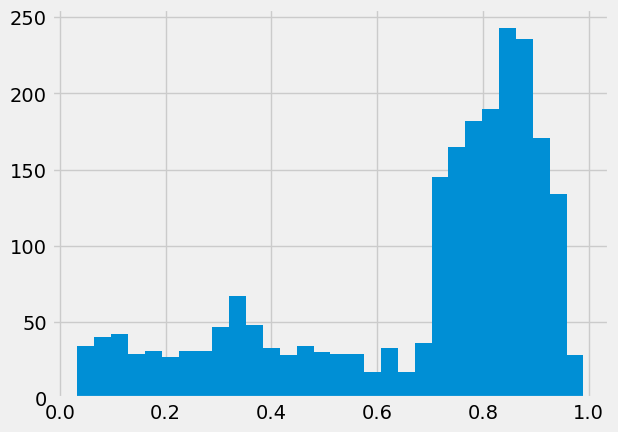

In [72]:
plt.hist(titanic.lrfit2_prob, bins=30)

In [73]:
# And I'm going to repeat "We are predicting death" a few times so
# I don't make a mistake constructing all these ... 
cutoff = np.arange(0.01, .99, .1)
FPR = []
TPR = []
SURVIVE = titanic.Survived 
PERISH = 1 - SURVIVE
for c in cutoff:
    PRED_SURV = titanic.lrfit2_prob  < c
    PRED_PRSH = (1- PRED_SURV)
    TP = sum( PERISH  * PRED_PRSH) 
    TN = sum(SURVIVE *  PRED_SURV)
    FP = sum(SURVIVE *  PRED_PRSH)
    FN = sum( PERISH * PRED_SURV)
    print( c,"\t", TP, TN, FP, FN)
    

0.01 	 1496.0 0.0 711.0 0.0
0.11 	 1493.0 91.0 620.0 3.0
0.21000000000000002 	 1486.0 179.0 532.0 10.0
0.31000000000000005 	 1463.0 266.0 445.0 33.0
0.41000000000000003 	 1404.0 362.0 349.0 92.0
0.51 	 1353.0 406.0 305.0 143.0
0.6100000000000001 	 1305.0 437.0 274.0 191.0
0.7100000000000001 	 1231.0 471.0 240.0 265.0
0.81 	 820.0 594.0 117.0 676.0
0.91 	 224.0 695.0 16.0 1272.0


In [ ]:
# Still with me?

In [74]:
cutoff = np.arange(0.01, .99, .01)
TNR = []
TPR = []
FPR = []
FNR = []
SURVIVE = titanic.Survived 
PERISH = 1 - SURVIVE
for c in cutoff:
    PRED_SURV = titanic.lrfit2_prob  < c
    PRED_PRSH = (1- PRED_SURV)
    TP = sum( PERISH  * PERISH) 
    TN = sum(SURVIVE *  PRED_SURV)
    FP = sum(SURVIVE *  PRED_PRSH)
    FN = sum( PERISH * PRED_SURV)
    TPR.append( TP / (TP + FN + 0.001) )
    TNR.append( TN / (TN + FP + 0.001) ) 
    FPR.append( FP / (TP + FP + 0.001)  ) 
    FNR.append( FN / (TN + FN + 0.001) ) 

TPR = np.array(TPR)
TNR = np.array(TNR)
FPR = np.array(FPR)
FNR = np.array(FNR)


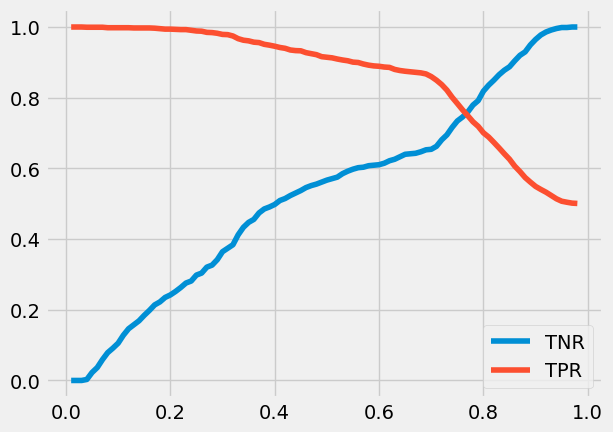

In [75]:
plt.plot( cutoff, TNR, label="TNR")
plt.plot( cutoff, TPR, label="TPR")
plt.legend()

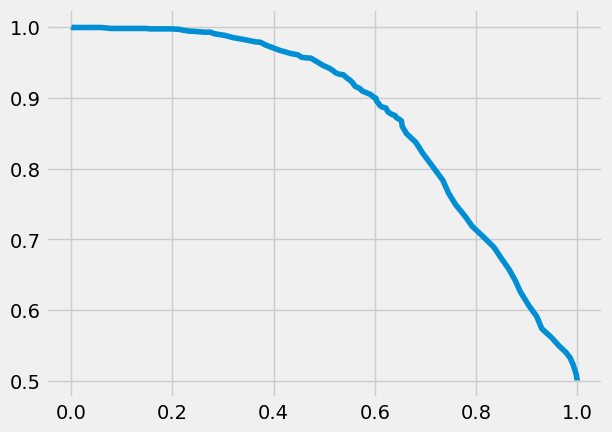

In [76]:
plt.plot( TNR, TPR)

(0.0, 1.0)

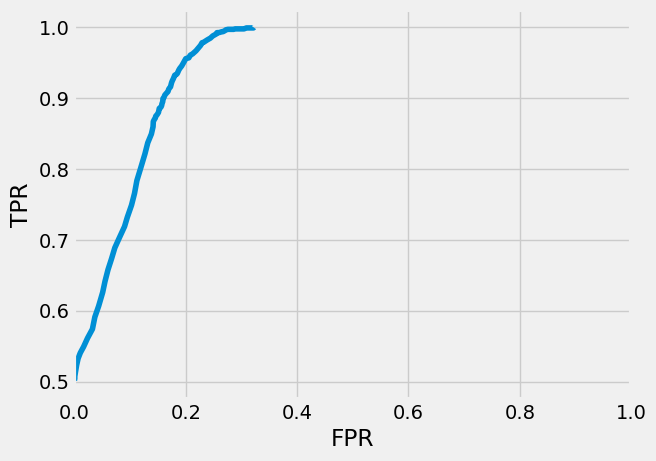

In [77]:
plt.plot( FPR, TPR)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim([0,1])
# This gives us the frontier of error rates that are achievable 
# (by selecting different values of cutoff).  Our optimium will 
# minimize Loss ( expected FPR, expected FNR )

# Good is up to the left on this graph.


In [ ]:
# Note the upper-right corner of this graph is to predict "Everybody dies"
# and get a True Postitive rate of 100% and a False Positive Rate of 34%.


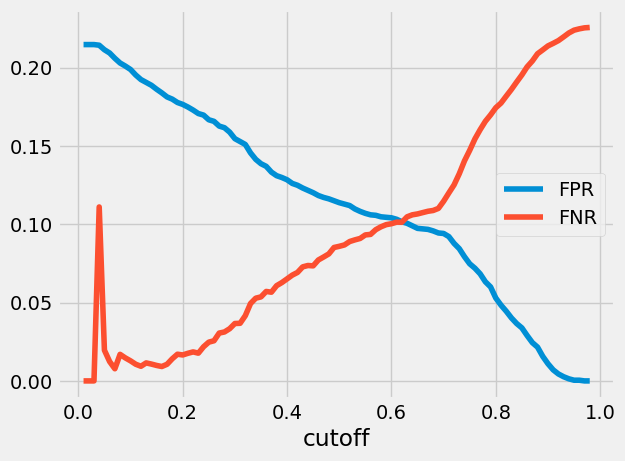

In [79]:
plt.plot( cutoff, FPR* 2/3 , label="FPR")
plt.plot( cutoff, FNR * 1/3, label = "FNR")
plt.xlabel("cutoff")
plt.legend()
# Another way to show the (one-dimensional) true positive / false positive
# tradeoff is in one dimension.
# If you had a particular ratio of FPR to FNR in mind you could set it here.
